In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fraud-detection' dataset.
Path to dataset files: /kaggle/input/fraud-detection


TRAIN SHAPE: (1296675, 23)
TEST SHAPE: (555719, 23)
NUMERIC FEATURES: ['Unnamed: 0', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'hour', 'day', 'month', 'weekday']
CATEGORICAL FEATURES: ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job']

TRAINING LogisticRegression

Confusion Matrix:
[[552172   1402]
 [  2094     51]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9962    0.9975    0.9968    553574
           1     0.0351    0.0238    0.0283      2145

    accuracy                         0.9937    555719
   macro avg     0.5157    0.5106    0.5126    555719
weighted avg     0.9925    0.9937    0.9931    555719

ROC-AUC: 0.3948
PR-AUC: 0.0043

TRAINING DecisionTree

Confusion Matrix:
[[543356  10218]
 [   325   1820]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9815    0.9904    553574
           1    

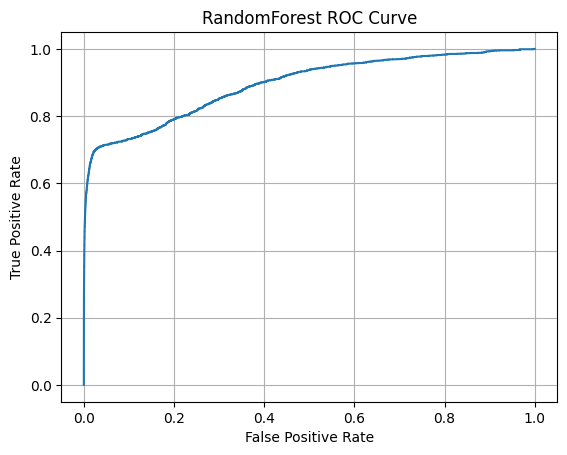

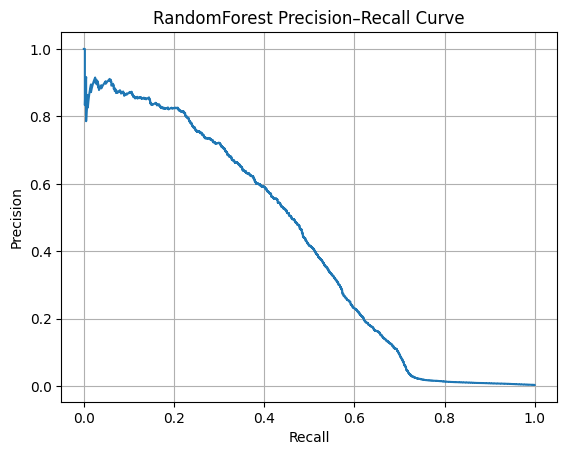


Saved model → /content/best_fraud_model.joblib


In [ ]:
# ======================
# CREDIT CARD FRAUD DETECTION – FULL MODEL PIPELINE
# ======================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

# ======================
# LOAD DATA
# ======================

train_path = "/kaggle/input/fraud-detection/fraudTrain.csv"
test_path  = "/kaggle/input/fraud-detection/fraudTest.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

print("TRAIN SHAPE:", df_train.shape)
print("TEST SHAPE:", df_test.shape)


# ======================
# CLEAN / PREPARE
# ======================

# Target column
target = "is_fraud"

# Drop identifier-like columns
drop_cols = ["trans_num", "cc_num", "dob"]

X_train = df_train.drop(columns=[target] + drop_cols)
y_train = df_train[target]

X_test = df_test.drop(columns=[target] + drop_cols)
y_test = df_test[target]

# Parse datetime field
X_train["trans_date_trans_time"] = pd.to_datetime(X_train["trans_date_trans_time"])
X_test["trans_date_trans_time"] = pd.to_datetime(X_test["trans_date_trans_time"])

# Create time features
for df in [X_train, X_test]:
    df["hour"] = df["trans_date_trans_time"].dt.hour
    df["day"] = df["trans_date_trans_time"].dt.day
    df["month"] = df["trans_date_trans_time"].dt.month
    df["weekday"] = df["trans_date_trans_time"].dt.weekday

# Drop raw timestamp
X_train = X_train.drop(columns=["trans_date_trans_time"])
X_test = X_test.drop(columns=["trans_date_trans_time"])


# ======================
# FEATURE TYPES
# ======================

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("NUMERIC FEATURES:", numeric_features)
print("CATEGORICAL FEATURES:", categorical_features)


# ======================
# PREPROCESSOR
# ======================

preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


# ======================
# MODELS TO TRAIN
# ======================

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(max_depth=8),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=-1)
}

results = {}


# ======================
# TRAIN & EVALUATE MODELS
# ======================

for name, model in models.items():
    print(f"\n====================")
    print(f"TRAINING {name}")
    print("====================")

    pipe = ImbPipeline(steps=[
        ("pre", preprocess),
        ("smote", SMOTE()),
        ("clf", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    results[name] = {
        "model": pipe,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "precision": precision,
        "recall": recall
    }


# ======================
# SELECT BEST MODEL (PR-AUC)
# ======================

best_model_name = max(results, key=lambda m: results[m]["pr_auc"])
best_model = results[best_model_name]["model"]

print(f"\n\nBEST MODEL: {best_model_name}")
print("PR-AUC =", results[best_model_name]["pr_auc"])


# ======================
# PLOT ROC & PR CURVE
# ======================

y_proba = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{best_model_name} ROC Curve")
plt.grid()
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{best_model_name} Precision–Recall Curve")
plt.grid()
plt.show()


# ======================
# SAVE BEST MODEL
# ======================
import joblib
joblib.dump(best_model, "/content/best_fraud_model.joblib")

print("\nSaved model → /content/best_fraud_model.joblib")

In [ ]:
import joblib
import pandas as pd

# Load the best model
best_model = joblib.load("/content/best_fraud_model.joblib")

# Define sample transactions for testing
# Note: 'Unnamed: 0' column is included with dummy values as it was part of numeric_features in training.

sample_transaction = {
    'Unnamed: 0': 0, # Dummy value
    'merchant': 'fraud_Abshire Inc',
    'category': 'shopping_net',
    'amt': 199.99,
    'first': 'John',
    'last': 'Doe',
    'gender': 'M',
    'street': '123 Elm Street',
    'city': 'Denver',
    'state': 'CO',
    'zip': 80202,
    'lat': 39.7392,
    'long': -104.9903,
    'city_pop': 600000,
    'job': 'Engineer',
    'unix_time': 1592470800, # Corresponding to 2020-06-18 14:00:00
    'merch_lat': 39.7401,
    'merch_long': -104.9912,
    'trans_date_trans_time': '2020-06-18 14:00:00'
}

fraud_like = {
    'Unnamed: 0': 1, # Dummy value
    'merchant': 'fraud_Random LLC',
    'category': 'misc_net',
    'amt': 2999.99,
    'first': 'Jane',
    'last': 'Public',
    'gender': 'F',
    'street': 'Unknown',
    'city': 'Unknown',
    'state': 'ZZ',
    'zip': 99999,
    'lat': 0.0,
    'long': 0.0,
    'city_pop': 10,
    'job': 'Unemployed',
    'unix_time': 1609372800, # Corresponding to 2020-12-31 03:00:00
    'merch_lat': 10.0,
    'merch_long': 10.0,
    'trans_date_trans_time': '2020-12-31 03:00:00' # High amount, suspicious location/time
}

non_fraud_like = {
    'Unnamed: 0': 2, # Dummy value
    'merchant': 'non_fraud_Local Market',
    'category': 'grocery_pos',
    'amt': 45.50,
    'first': 'Peter',
    'last': 'Jones',
    'gender': 'M',
    'street': '101 Oak Ave',
    'city': 'San Francisco',
    'state': 'CA',
    'zip': 94101,
    'lat': 37.7749,
    'long': -122.4194,
    'city_pop': 870000,
    'job': 'Software Engineer',
    'unix_time': 1609372800,
    'merch_lat': 37.7750,
    'merch_long': -122.4195,
    'trans_date_trans_time': '2020-12-31 10:00:00' # Normal amount, common category
}

df_samples = pd.DataFrame([sample_transaction, fraud_like, non_fraud_like])

# Apply feature engineering steps as done during training
df_samples["trans_date_trans_time"] = pd.to_datetime(df_samples["trans_date_trans_time"])
df_samples["hour"] = df_samples["trans_date_trans_time"].dt.hour
df_samples["day"] = df_samples["trans_date_trans_time"].dt.day
df_samples["month"] = df_samples["trans_date_trans_time"].dt.month
df_samples["weekday"] = df_samples["trans_date_trans_time"].dt.weekday
df_samples = df_samples.drop(columns=["trans_date_trans_time"])

# Make predictions
preds = best_model.predict(df_samples)
probs = best_model.predict_proba(df_samples)[:, 1] # Probability of being fraud

# Display the results
results_df = pd.DataFrame({
    'Fraud_Prob': probs,
    'Pred': preds
})
display(results_df)


,Fraud_Prob,Pred
0,0.481242,0
1,0.574462,1
2,0.485572,0
